<a href="https://colab.research.google.com/github/PGCodehub/BasicNeworks/blob/master/Copy_of_GoT_GAN_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to Generate Game of Thrones Characters With StyleGAN

Hi, welcome to this tutorial on generating and messsing around with Game of Thrones characters uing StyleGAN.

If you're reading this, I'm assuming that you came here after reading the [article](https://blog.nanonets.com/stylegan-got/)  that accompanies this notebook. If you didn't, [CHECK IT OUT NOW!](https://blog.nanonets.com/stylegan-got/)

Once you're done, we can get started with the good stuff.

# Setting thigs up

StyleGAN is a massive model that can take weeks to train. So for this tutorial, we're going to use a pretrained model that Nvidia open-sourced. You can find the official implementation [here](https://github.com/NVlabs/stylegan).

But here, we're going to use a version of that repo that I forked and modified specifically to save you time when using Game of Thrones Characters.

So first, let's clone the repo and move into it.

In [0]:
! git clone https://github.com/iyaja/stylegan-encoder.git
import os
os.chdir("stylegan-encoder")

Next, we need to import a few required libraries. You can pretty much leave this part alone, but be sure to run it.

In [0]:
import os
import pickle
import PIL.Image
import numpy as np
import dnnlib
import dnnlib.tflib as tflib
import config
from encoder.generator_model import Generator

import matplotlib.pyplot as plt
%matplotlib inline

Like I mentioned, we're going to use a pretrained StyleGAN, which was trained on the [FFHQ dataset](https://www.github.com/NVlabs/ffhq-dataset). This code block downloads the weights and initializes the network to make it easy for us to play around with the model via a high-level interface.

In [0]:
URL_FFHQ = 'https://s3-us-west-2.amazonaws.com/nanonets/blogs/karras2019stylegan-ffhq-1024x1024.pkl'

tflib.init_tf()
with dnnlib.util.open_url(URL_FFHQ, cache_dir=config.cache_dir) as f:
    generator_network, discriminator_network, Gs = pickle.load(f)

generator = Generator(Gs, batch_size=1, randomize_noise=False)

We'll also define these helper functions. It may not seem intuitive now, but these functions will make it really easy to iterate quickly later on.

In [0]:
def generate_image(latent_vector):
    latent_vector = latent_vector.reshape((1, 18, 512))
    generator.set_dlatents(latent_vector)
    img_array = generator.generate_images()[0]
    img = PIL.Image.fromarray(img_array, 'RGB')
    #return img
    return img.resize((256, 256))

def move_and_show(latent_vector, direction, coeffs):
    fig,ax = plt.subplots(1, len(coeffs), figsize=(15, 10), dpi=80)
    for i, coeff in enumerate(coeffs):
        new_latent_vector = latent_vector.copy()
        new_latent_vector[:8] = (latent_vector + coeff*direction)[:8]
        ax[i].imshow(generate_image(new_latent_vector))
        ax[i].set_title('Coeff: %0.1f' % coeff)
    [x.axis('off') for x in ax]
    plt.show()

I've also precomputed latent representations of a few popular Game of Thrones Characters. Quality isn't top-notch, though, since I did zero fine tuning on top of the baseline StyleGAN.

[Dmitry Nikitko ](https://www.linkedin.com/in/puzer/) has an excellent [GitHub repo](https://github.com/Puzer/stylegan-encoder) which includes an "encoder" for StyleGAN. The repo has latent directions like smile, age, and gender built-in, so we'll load those too.

In [0]:
# Loading already learned representations
jon = np.load('latent_representations/jon.npy')
jon_2 = np.load('latent_representations/jon_2.npy')
tyrion = np.load('latent_representations/tyrion.npy')
daenerys = np.load('latent_representations/daenerys.npy')
drogo = np.load('latent_representations/drogo.npy')
bran = np.load('latent_representations/bran.npy')
cersei = np.load('latent_representations/cersei.npy')
jaime = np.load('latent_representations/jaime.npy')
theon = np.load('latent_representations/theon.npy')
night_king_1 = np.load('latent_representations/night_king_1.npy')
night_king_2 = np.load('latent_representations/night_king_2.npy')

# Loading already learned latent directions
smile_direction = np.load('ffhq_dataset/latent_directions/smile.npy')
gender_direction = np.load('ffhq_dataset/latent_directions/gender.npy')
age_direction = np.load('ffhq_dataset/latent_directions/age.npy')

If you want to play around with your own images, go ahead! All you have to do is make sure you have the right folders set up, then upload your face images to the 'raw_images' folder (without quotes) and these scripts by uncommenting the appropriate lines.

In [0]:
# First, set up the required folders

#os.mkdir('raw_images')
#os.mkdir('aligned_images')
#os.mkdir('generated_images')

# Then, run these scripts

# 1) Extract and align faces from images
#!python align_images.py raw_images/ aligned_images/

# 2) Find latent representation of aligned images
#!python encode_images.py aligned_images/ generated_images/ latent_representations/

# Character Transformations

Using the latent representation of any character along with the learned latent directions, you can adjust three traits of any charcter: smile, age, and gender. This is done via the `move_and_show()` function, which takes three arguments: a latent vector, a latent direction, and an array of coefficients. It then performs the following computation:


$$ \text{new latent vector} = \text{latent vector} + (\text{coefficient} * \text{latent direction} )$$


The new latent vectors are passed through the StyleGAN genertor, and the resulting images are plotted. You can refer back to the previous section to go through the implementation of `move_and_show()`.

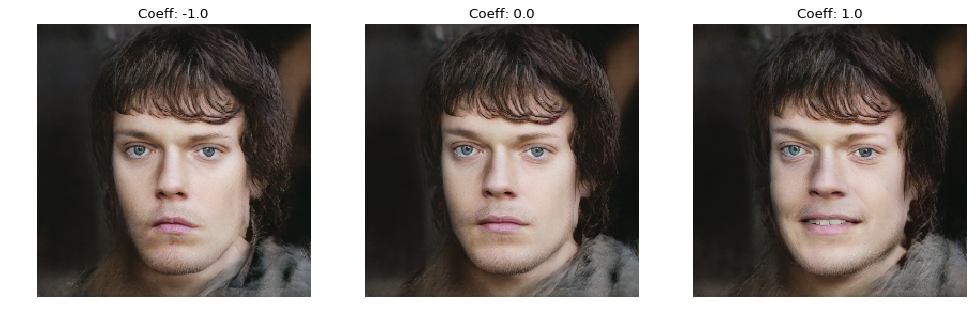

In [0]:
move_and_show(theon, smile_direction, [-1, 0, 1])

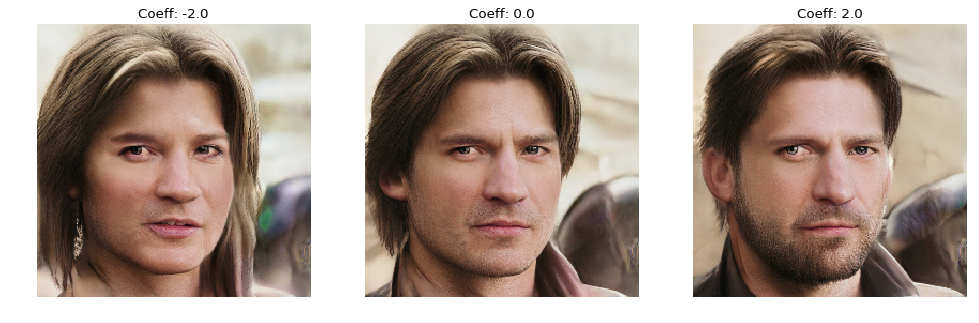

In [0]:
move_and_show(jaime, gender_direction, [-2, 0, 2])

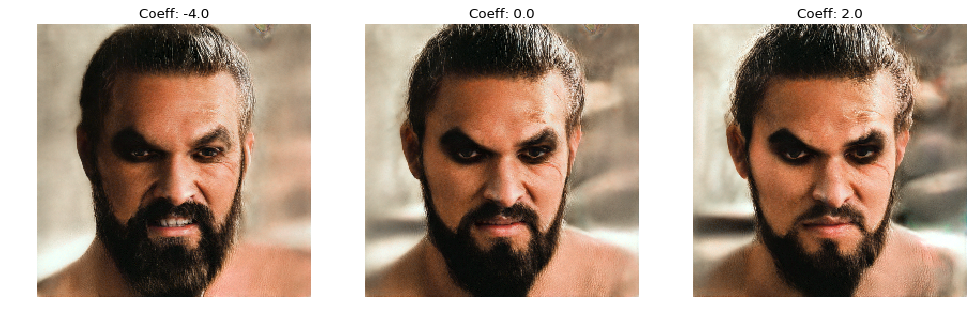

In [0]:
move_and_show(drogo, age_direction, [-4, 0, 2])

#Character Fusion

We can also try mixing characters together to find an "average" of the two. The easiest way to do this is to simply take an average of the two latent vectors and generate an image using the average latent vector. You can also adjust how much of each character you want by changing `alpha`.


Now for the moment of truth -- Let's see what the future protector of the realm will look like!

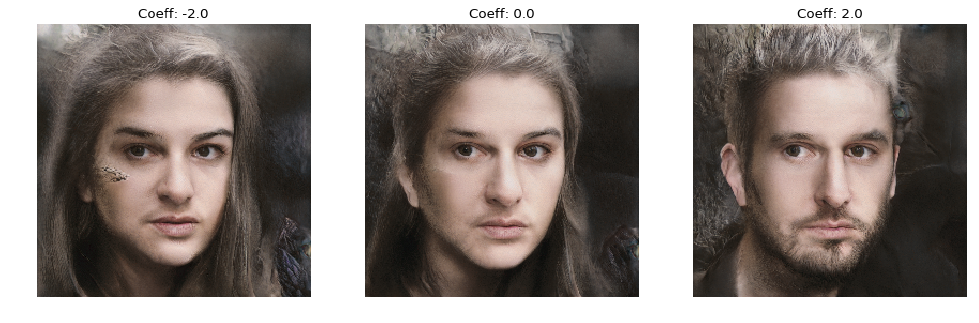

In [0]:
alpha = 0.5

mix = (((alpha)*jon)+((1-alpha)*daenerys))

move_and_show(mix, gender_direction, [-2, 0, 2])

Note that above, you basically created a new character, so can save that latent and do the age, gender, and smile transforms as shown above.

The second, and perhaps more interesting way to fuse characters i through Nvidia's style mixing technique. Refer back to the [main article](https://blog.nanonets.com/stylegan-got/https://blog.nanonets.com/got-gan) to learn how this works. The code below is a modification of Nvidia's style mixing implementation.

In [0]:
def draw_style_mixing_figure(png, Gs, w, h, src_dlatents, dst_dlatents, style_ranges):
    print(png)
    #src_dlatents = Gs.components.mapping.run(src_latents, None) # [seed, layer, component]
    #dst_dlatents = Gs.components.mapping.run(dst_latents, None)
    src_images = Gs.components.synthesis.run(src_dlatents, randomize_noise=False, **synthesis_kwargs)
    dst_images = Gs.components.synthesis.run(dst_dlatents, randomize_noise=False, **synthesis_kwargs)

    canvas = PIL.Image.new('RGB', (w * (len(src_dlatents) + 1), h * (len(dst_dlatents) + 1)), 'white')
    for col, src_image in enumerate(list(src_images)):
        canvas.paste(PIL.Image.fromarray(src_image, 'RGB'), ((col + 1) * w, 0))
    for row, dst_image in enumerate(list(dst_images)):
        canvas.paste(PIL.Image.fromarray(dst_image, 'RGB'), (0, (row + 1) * h))
        row_dlatents = np.stack([dst_dlatents[row]] * len(src_dlatents))
        row_dlatents[:, style_ranges[row]] = src_dlatents[:, style_ranges[row]]
        row_images = Gs.components.synthesis.run(row_dlatents, randomize_noise=False, **synthesis_kwargs)
        for col, image in enumerate(list(row_images)):
            canvas.paste(PIL.Image.fromarray(image, 'RGB'), ((col + 1) * w, (row + 1) * h))
    canvas.save(png)
    return canvas.resize((512,512))

results/style-mixing.png


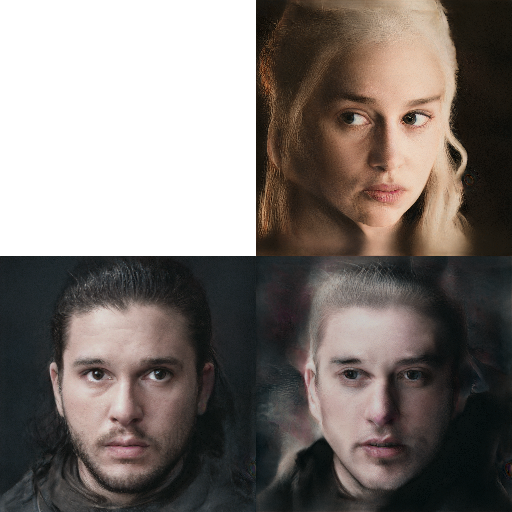

In [0]:
tflib.init_tf()
synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), minibatch_size=1)
_Gs_cache = dict()

draw_style_mixing_figure(os.path.join(config.result_dir, 'style-mixing.png'), Gs, w=1024, h=1024, src_dlatents=daenerys.reshape((1, 18, 512)), dst_dlatents=jon_2.reshape((1, 18, 512)), style_ranges=[range(6,14)])

Surprisingly, I found the simple averaging method to produce better results, and I'm not sure why that's the case. I'd encourage you to keep trying Nvidia's style mixing method with different paramets, since you might get some really cool results.

# Interpolation Videos


This secion will prduce one of the most exciting reults -- GAN interpolation videos. These videos perform smooth transitions between various images, which you'll only understand if you watch one yourself. So to make your own, start by tweaking these parameters to your preferences (note: this can increase the time it takes to generate a video).

In [0]:
duration_sec = 5.0
smoothing_sec = 1.0
mp4_fps = 20
num_frames = int(np.rint(duration_sec * mp4_fps))

Next, we'll define two helper functions like the ones from the start of this notebook. Except, these will reurn image arrays instead.

In [0]:
def generate_image_for_video(latent_vector):
    latent_vector = latent_vector.reshape((1, 18, 512))
    generator.set_dlatents(latent_vector)
    img_array = generator.generate_images()[0]

    return img_array
  
  
def move_for_video(latent_vector, direction, coeff):
  
  new_latent_vector = latent_vector.copy()
  new_latent_vector[:8] = (latent_vector + coeff*direction)[:8]
  
  img_array = generate_image(new_latent_vector)
  
  return img_array

Finally, run this code block to generate cool videos. The results will be saved under the reults folder. Follow the comments to generate different kinds of videos, and enjoy!

In [0]:
# If you're interpolating between two characters, set these characters here
char1 = daenerys
char2 = jaime

# This creates an nd array that stores all the image frames fot cross-character interpolation
src_images = np.stack(generate_image_for_video((0.01*alpha*char2)+((1-(0.01*alpha))*char1)) for alpha in range (100))


# Uncomment the next line if you want to do a character transforation video, and choose the arguments as per your requirement
#src_images = np.stack(move_for_video(dany_meme, smile_direction, (0.02*alpha)) for alpha in range (-100,100))


def make_frame(t):
    frame_idx = int(np.clip(np.round(t * mp4_fps), 0, num_frames - 1))
    src_image = src_images[frame_idx]
    return np.array(src_image)

# Generate video.
import moviepy.editor
mp4_file = 'results/interpolate.mp4'
mp4_codec = 'libx264'
mp4_bitrate = '5M'

video_clip = moviepy.editor.VideoClip(make_frame, duration=duration_sec)
video_clip.write_videofile(mp4_file, fps=mp4_fps, codec=mp4_codec, bitrate=mp4_bitrate)